### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

## Preprocessing

In [2]:
# Load Data
data = pd.read_csv('small_train.csv')
data.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year
0,1,WLT-Group,2017-11-20,Team Leader,"Stevenage, England, England",Avoid these idiots,you can leave at any time,no payrises\rno incentive to do well\rIf you d...,2017
1,1,ASDA,2019-09-02,Home Delivery Driver,"Dundonald, Northern Ireland, Northern Ireland",Gack pure and utter,"Leaving the store, customers were great even w...","Poor management, awful attitude to they're staff",2019
2,1,McDonald-s,2019-09-26,Manager,"Dallas, TX",bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019
3,1,Adecco,2014-12-09,Technical Lead for IBM,Bangalore,Irresponsible company after joining,Nothing positive about this company,1)After joining and deployed to client locatio...,2014
4,1,Grant-Thornton,2020-10-20,Senior Associate,NaN,Discriminate against women in Cyber Risk,The initial pay is what draws you in,This is a place where boys club goes to a whol...,2020


In [3]:
# Remove unnecessary columns from data
cols_to_drop = ['date_review', 'location', 'job_title']
data.drop(columns=cols_to_drop, inplace=True)
data.head()

,overall_rating,firm,headline,pros,cons,year
0,1,WLT-Group,Avoid these idiots,you can leave at any time,no payrises\rno incentive to do well\rIf you d...,2017
1,1,ASDA,Gack pure and utter,"Leaving the store, customers were great even w...","Poor management, awful attitude to they're staff",2019
2,1,McDonald-s,bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019
3,1,Adecco,Irresponsible company after joining,Nothing positive about this company,1)After joining and deployed to client locatio...,2014
4,1,Grant-Thornton,Discriminate against women in Cyber Risk,The initial pay is what draws you in,This is a place where boys club goes to a whol...,2020


In [4]:
# Remove rows with missing values in following columns
cols = ['firm', 'headline', 'pros', 'cons']
len_before = len(data)
df = data.dropna(subset=cols)
len_after = len(df)
print("Rows Dropped: ", len_before - len_after)


Rows Dropped:  252


In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Removing stopwords
    # tokens = [word for word in tokens if not word in stop_words]
    # Lemmatization and Stemming
    
    return ' '.join(tokens)

df['headline'] = df['headline'].apply(preprocess)
df['pros'] = df['pros'].apply(preprocess)
df['cons'] = df['cons'].apply(preprocess)

In [11]:
df.head()

,overall_rating,firm,headline,pros,cons,year
0,1,WLT-Group,avoid these idiots,you can leave at any time,no payrises no incentive to do well if you dar...,2017
1,1,ASDA,gack pure and utter,leaving the store customers were great even wi...,poor management awful attitude to they staff,2019
2,1,McDonald-s,bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019
3,1,Adecco,irresponsible company after joining,nothing positive about this company,after joining and deployed to client location ...,2014
4,1,Grant-Thornton,discriminate against women in cyber risk,the initial pay is what draws you in,this is a place where boys club goes to a whol...,2020


## Sentiment Analysis - Constructing Features

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sid.polarity_scores(str(text).lower())['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hp/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
# Constructing Features
df['headline_sentiment'] = df['headline'].apply(get_sentiment_score)
df['pros_sentiment'] = df['pros'].apply(get_sentiment_score)
df['cons_sentiment'] = df['cons'].apply(get_sentiment_score)

df['total_sentiment'] = df['headline_sentiment'] + df['pros_sentiment'] + df['cons_sentiment']
df['avg_sentiment'] = df['total_sentiment'] / 3

df['pros_length'] = df['pros'].apply(lambda x: len(x.split()))
df['cons_length'] = df['cons'].apply(lambda x: len(x.split()))

In [14]:
# Save sentimented data
csv_post_sentiment = './sentimented_data.csv'
df.to_csv(csv_post_sentiment, index=False)

## Training

### Feature and Target Data

In [5]:
df = pd.read_csv("./sentimented_data.csv")

data_copy = df

df.head()

,overall_rating,firm,headline,pros,cons,year,headline_sentiment,pros_sentiment,cons_sentiment,total_sentiment,avg_sentiment,pros_length,cons_length
0,1,WLT-Group,avoid these idiots,you can leave at any time,no payrises no incentive to do well if you dar...,2017,-0.2960,-0.0516,-0.4939,-0.8415,-0.280500,6,20
1,1,ASDA,gack pure and utter,leaving the store customers were great even wi...,poor management awful attitude to they staff,2019,0.0000,0.5106,-0.7269,-0.2163,-0.072100,14,7
2,1,McDonald-s,bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019,-0.5994,-0.4939,-0.4939,-1.5872,-0.529067,7,5
3,1,Adecco,irresponsible company after joining,nothing positive about this company,after joining and deployed to client location ...,2014,-0.4404,-0.4449,0.4692,-0.4161,-0.138700,5,143
4,1,Grant-Thornton,discriminate against women in cyber risk,the initial pay is what draws you in,this is a place where boys club goes to a whol...,2020,-0.2732,-0.1027,0.6683,0.2924,0.097467,8,185


In [6]:
from sklearn.preprocessing import LabelEncoder

# Convert firm to numerical value
le = LabelEncoder()
df['firm'] = le.fit_transform(df['firm'])
df['year'] = le.fit_transform(df['year'])

df.head()

,overall_rating,firm,headline,pros,cons,year,headline_sentiment,pros_sentiment,cons_sentiment,total_sentiment,avg_sentiment,pros_length,cons_length
0,1,404,avoid these idiots,you can leave at any time,no payrises no incentive to do well if you dar...,9,-0.2960,-0.0516,-0.4939,-0.8415,-0.280500,6,20
1,1,4,gack pure and utter,leaving the store customers were great even wi...,poor management awful attitude to they staff,11,0.0000,0.5106,-0.7269,-0.2163,-0.072100,14,7
2,1,227,bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,11,-0.5994,-0.4939,-0.4939,-1.5872,-0.529067,7,5
3,1,13,irresponsible company after joining,nothing positive about this company,after joining and deployed to client location ...,6,-0.4404,-0.4449,0.4692,-0.4161,-0.138700,5,143
4,1,149,discriminate against women in cyber risk,the initial pay is what draws you in,this is a place where boys club goes to a whol...,12,-0.2732,-0.1027,0.6683,0.2924,0.097467,8,185


In [54]:
features_to_drop = ['overall_rating', 'headline', 'pros', 'cons', 'avg_sentiment', 'year']

y = df['overall_rating']
X = df.drop(columns=features_to_drop)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Neural Network

In [18]:
from sklearn.neural_network import MLPRegressor

# Model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='logistic', max_iter=1000,solver='adam', random_state=42)
nn_model.fit(X_train, y_train)

y_pred_train = np.round(np.clip(nn_model.predict(X_train), 1, 5))
y_pred_test = np.round(np.clip(nn_model.predict(X_test), 1, 5))

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Train MSE: {mse_train}')
print(f'Train R2: {r2_train}')

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test MSE: {mse_test}')
print(f'Test R2: {r2_test}')


Train MSE: 0.8615253515125693
Train R2: 0.30184952627018613
Test MSE: 0.8825062656641603
Test R2: 0.28337174396601095


### Random Forest Regressor

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf1_model = RandomForestRegressor(random_state=42)
rf1_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [74]:
y_pred_train = np.clip(rf1_model.predict(X_train), 1, 5)
y_pred_test = np.clip(rf1_model.predict(X_test), 1, 5)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Train MSE: {mse_train}')
print(f'Train R2: {r2_train}')

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test MSE: {mse_test}')
print(f'Test R2: {r2_test}')

Train MSE: 0.1183250185430041
Train R2: 0.9041134801142505
Test MSE: 0.8177386594620998
Test R2: 0.3359654744424153


### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf2_model = RandomForestClassifier(random_state=42)
rf2_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
y_pred_train = rf2_model.predict(X_train)
y_pred_test = rf2_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Train MSE: {mse_train}')
print(f'Train R2: {r2_train}')
print(f'Training accuracy: {train_accuracy}\n')

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test MSE: {mse_test}')
print(f'Test R2: {r2_test}')
print(f'Training accuracy: {test_accuracy}')

Train MSE: 0.11402541417078123
Train R2: 0.9075977314181128
Training accuracy: 0.9472292538660116

Test MSE: 1.1629573934837092
Test R2: 0.05563488763804503
Training accuracy: 0.4209022556390977


### Confusion Matrix

In [75]:
from sklearn.metrics import confusion_matrix
from ISLP import confusion_table

y_pred_train_rounded = np.round(y_pred_train)
y_pred_test_rounded = np.round(y_pred_test)

accuracy = accuracy_score(y_train, y_pred_train_rounded)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_train, y_pred_train_rounded)
print("Confusion Matrix")
print(cm)

confusion_table(y_train, y_pred_train_rounded)

Accuracy: 0.8697837038522269
Confusion Matrix
[[ 2131  2119    25     6     0]
 [    0  3820  2051    14     0]
 [    0   191 17049  1563     0]
 [    0     2   748 27130    66]
 [    0     0    16  3590 19277]]


Truth,1.0,2.0,3.0,4.0,5.0
Predicted,,,,,
1.0,2131,2119,25,6,0
2.0,0,3820,2051,14,0
3.0,0,191,17049,1563,0
4.0,0,2,748,27130,66
5.0,0,0,16,3590,19277


## Predictions

In [47]:
def process(data):
    data.drop(columns=['overall_rating', 'date_review', 'job_title', 'location'], inplace=True)
    
    # Check for missing values in the provided columns
    cols = ['headline', 'pros', 'cons']
    data[cols].isna().any()

    data['cons'].fillna('', inplace=True)
    data['headline'].fillna('', inplace=True)

    # Construct features
    data['headline'].apply(preprocess)
    data['pros'].apply(preprocess)
    data['cons'].apply(preprocess)

    data['headline_sentiment'] = data['headline'].apply(get_sentiment_score)
    data['pros_sentiment'] = data['pros'].apply(get_sentiment_score)
    data['cons_sentiment'] = data['cons'].apply(get_sentiment_score)
    data['total_sentiment'] = data['headline_sentiment'] + data['pros_sentiment'] + data['cons_sentiment']
    data['pros_length'] = data['pros'].apply(lambda x: len(x.split()))
    data['cons_length'] = data['cons'].apply(lambda x: len(x.split()))
    
    data = data.drop(columns=['headline', 'pros', 'cons', 'year'])
    return data

In [49]:
data_pred = pd.read_csv('test_data.csv')
data_pred.head()

# Preprocess
data_pred = process(data_pred)
data_pred['firm'] = le.fit_transform(data_pred['firm'])

# Predict
predictions = rf1_model.predict(data_pred)

# Save Predictions
predicted_data = pd.DataFrame(predictions, columns=["Overall Rating"])
predicted_data.to_csv("final_predictions.csv", index=False, header=False)

In [5]:
import pandas as pd

predictions = pd.read_csv('final_predictions.csv')
predictions = predictions[3:]
predictions.head()

,20939989
3,4.21
4,3.28
5,2.38
6,4.08
7,3.908666666666667


## Graphs

### Feature Importance

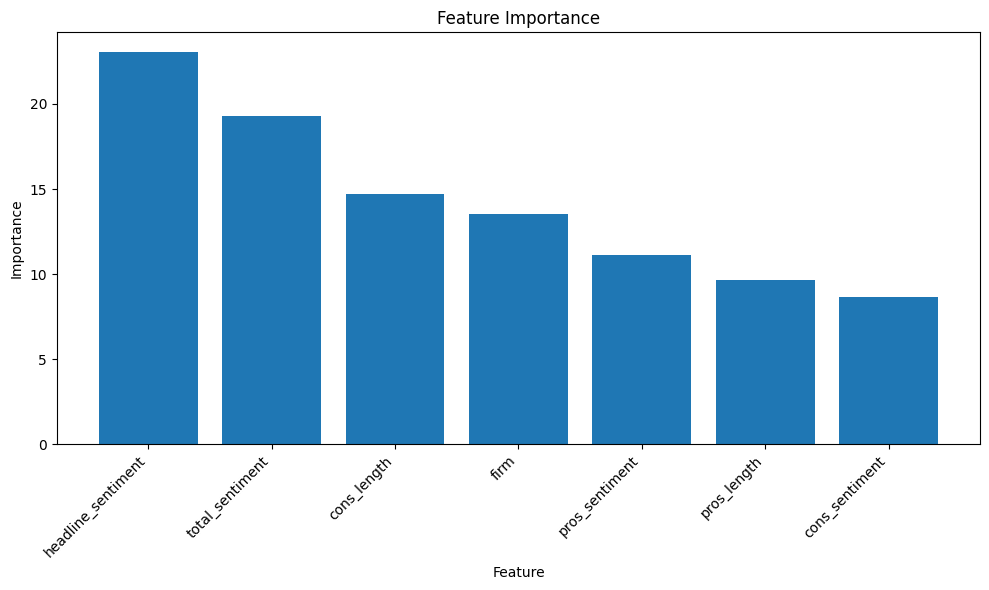

In [60]:
# Get feature importances
feature_importances = rf1_model.feature_importances_ * 100
feature_names = rf1_model.feature_names_in_

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Feature Correlation

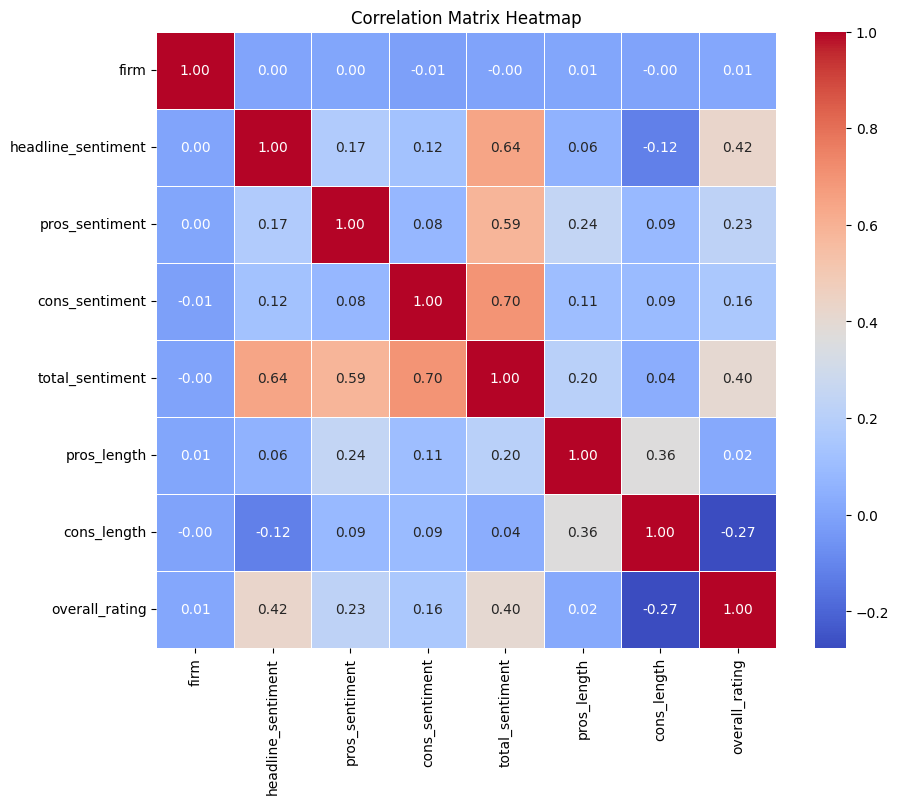

In [61]:
import seaborn as sns

cols = np.append(feature_names,'overall_rating')
correlation_matrix = data_copy[cols].corr()

pd.set_option('display.max_columns', None)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Feature Distribution

Index(['firm', 'headline_sentiment', 'pros_sentiment', 'cons_sentiment',
       'total_sentiment', 'pros_length', 'cons_length'],
      dtype='object')


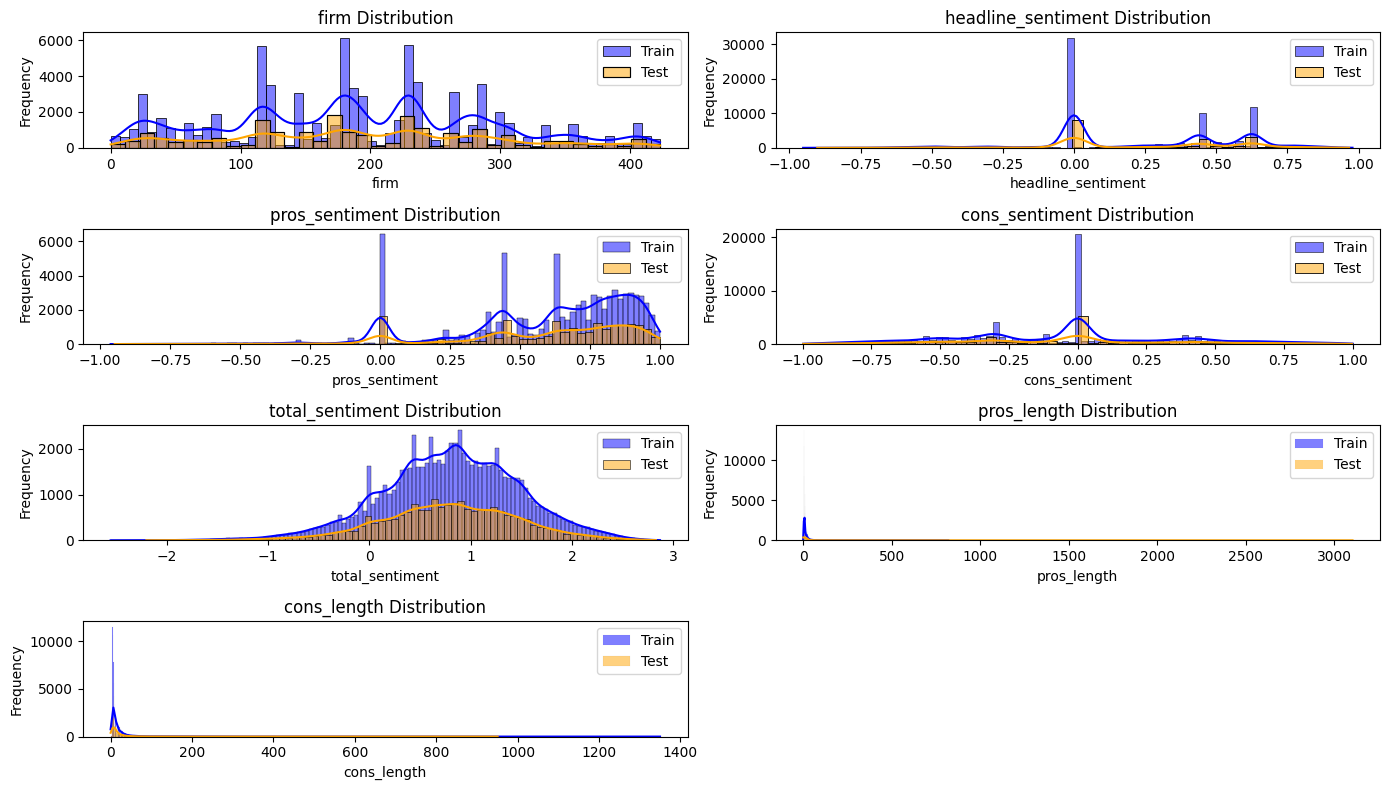

In [64]:
plt.figure(figsize=(14, 8))

print(X_train.columns)

num_cols = len(X_train.columns)
num_rows = (num_cols // 2) + (num_cols % 2)  # Calculate the number of rows needed for the subplot grid

for i, col in enumerate(X_train.columns):
    plt.subplot(num_rows, 2, i+1)  # Adjust the subplot layout according to your number of features
    sns.histplot(X_train[col], color='blue', kde=True, label='Train', alpha=0.5)
    sns.histplot(X_test[col], color='orange', kde=True, label='Test', alpha=0.5)
    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

### Prediction Errors

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.1)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

### Word Clouds

In [84]:
data = pd.read_csv('small_train.csv')

stop_words = set(stopwords.words('english'))

def process_text(text):
    tokens = word_tokenize(str(text))
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if not word in stop_words]
    return ' '.join(tokens)
    
data['headline'] = data['headline'].apply(process_text)
data['pros'] = data['pros'].apply(process_text)
data['cons'] = data['cons'].apply(process_text)

data_rating = []
data_rating.append(data[data['overall_rating'] == 1])
data_rating.append(data[data['overall_rating'] == 2])
data_rating.append(data[data['overall_rating'] == 3])
data_rating.append(data[data['overall_rating'] == 4])
data_rating.append(data[data['overall_rating'] == 5])


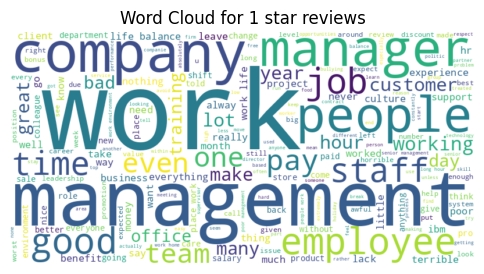

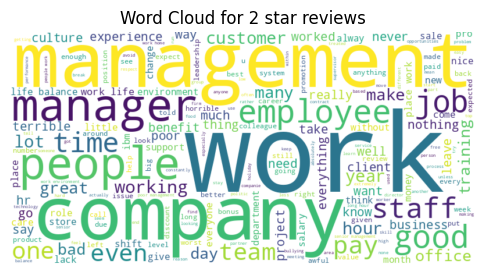

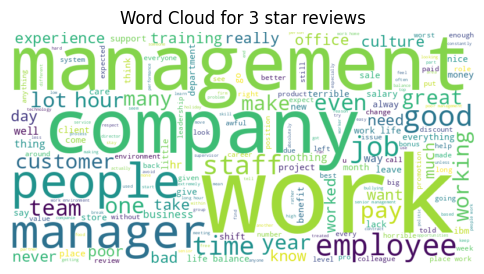

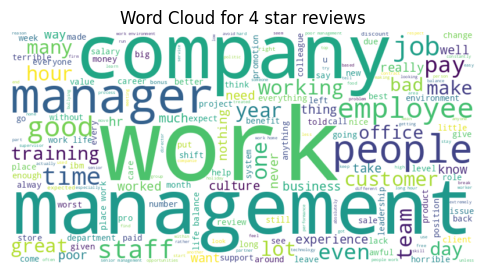

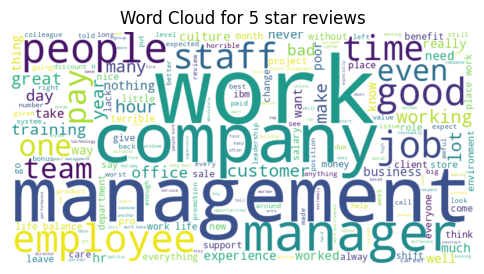

In [83]:
from wordcloud import WordCloud

for i in range(5):
    words = pd.concat([data_rating[0]['headline'], data_rating[0]['pros'], data_rating[0]['cons']])
    
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    
    # Plot word clouds
    plt.figure(figsize=(6, 4))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {i + 1} star reviews')
    plt.axis('off')
    plt.show()

## Insights

In [85]:
df = pd.read_csv("./sentimented_data.csv")

# Split data based on high and low ratings
high_ratings = df[(df['overall_rating'] == 4) | (df['overall_rating'] == 5)]
low_ratings = df[(df['overall_rating'] == 1) | (df['overall_rating'] == 2)]

In [86]:
from nltk.corpus import stopwords

# Remove stop words
stop_words = stopwords.words('english') + ['work']

def remove_stop_words(text):
    tokens = [word for word in str(text).split() if not word in stop_words]
    return tokens

high_pros = high_ratings['pros'].apply(remove_stop_words)
low_cons = low_ratings['cons'].apply(remove_stop_words)

In [87]:
from nltk.util import ngrams
from collections import Counter

# Function to extract trigrams from text and convert them into phrases
def extract_trigram_phrases(text_series):
    trigram_phrases = []
    for text in text_series:
        trigrams = ngrams(text, 3)
        phrases = [' '.join(trigram) for trigram in trigrams]
        trigram_phrases.extend(phrases)
    return trigram_phrases

# Extract trigrams from high pros and low cons text
high_pros_trigrams = extract_trigram_phrases(high_pros)
low_cons_trigrams = extract_trigram_phrases(low_cons)

# Count the occurrences of each trigram
high_pros_trigrams_counts = Counter(high_pros_trigrams)
low_cons_trigrams_counts = Counter(low_cons_trigrams)

# Print the most common trigrams for high pros and low cons
print("Top trigrams in high pros:")
for trigram, count in high_pros_trigrams_counts.most_common(8):
    print(trigram, ":", count)

print("\nTop trigrams in low cons:")
for trigram, count in low_cons_trigrams_counts.most_common(8):
    print(trigram, ":", count)

Top trigrams in high pros:
good life balance : 987
life balance good : 474
good working environment : 390
great life balance : 388
flexible working hours : 348
great people great : 282
good pay good : 238
great place learn : 211

Top trigrams in low cons:
long working hours : 78
high staff turnover : 47
poor life balance : 42
treat employees like : 24
high turnover rate : 23
poor management poor : 23
get things done : 22
management care employees : 22


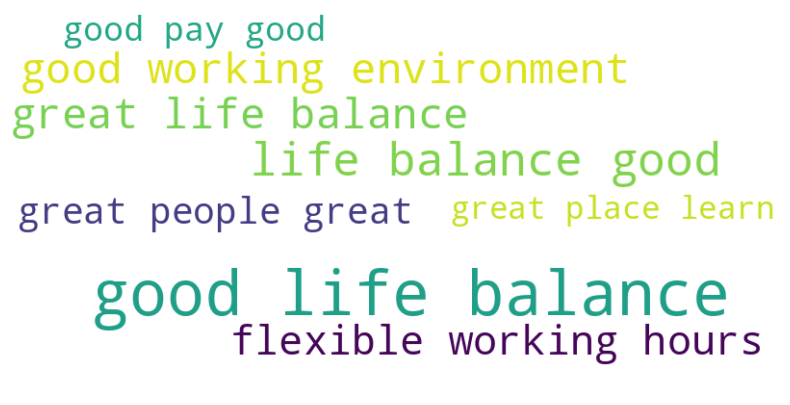

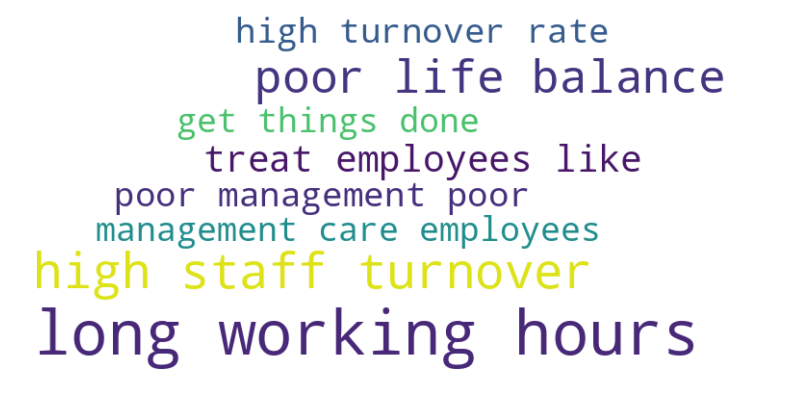

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud from a dictionary of word frequencies
def generate_wordcloud(word_freq_dict):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud for the top 10 most common high pros trigrams
generate_wordcloud(dict(high_pros_trigrams_counts.most_common(8)))

# Generate word cloud for the top 10 most common low cons trigrams
generate_wordcloud(dict(low_cons_trigrams_counts.most_common(8)))